In [1]:
import btrack
import zarr
import os
import napari
from macrohet import dataio
import glob
import numpy as np

In [2]:
expt_ID = 'ND0004'
base_dir = f'/mnt/SYNO/macrohet_syno/data/{expt_ID}/'
metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,replicate_number=False)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
acq_ID = (3, 4)
image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')
zarr_group = zarr.open(image_dir, mode='r')


Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


In [8]:
%%time
images = zarr_group.images[:,1,2,...]

CPU times: user 9.33 s, sys: 4.35 s, total: 13.7 s
Wall time: 4.24 s


In [9]:
images.shape

(154, 6048, 6048)

# comparing btrack to trackastra

In [12]:
with btrack.io.HDF5FileHandler(os.path.join(f'/mnt/SYNO/macrohet_syno/data/{expt_ID}/labels/cpv3/{acq_ID}.h5'), #macrohet_seg_model 
                                           'r', 
                                           obj_type='obj_type_1'
                                           ) as reader:
                bsegmentation = reader.segmentation
                btracks = reader.tracks

[INFO][2024/10/23 12:37:24 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0004/labels/cpv3/(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0004/labels/cpv3/(3, 4).h5...
[INFO][2024/10/23 12:37:43 pm] Loading segmentation (154, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (154, 6048, 6048)
[INFO][2024/10/23 12:37:43 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/10/23 12:37:43 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/10/23 12:37:43 pm] Loading objects/obj_type_1 (71403, 5) (71403 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (71403, 5) (71403 filtered: None)
[INFO][2024/10/23 12:37:45 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0004/labels/cpv3/(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0004/labels/cpv3/(3, 4).h5


In [46]:

# Initialize a list to hold the rows of tracking data
btracks_data = []

# Loop through each track in btracks and extract the ID, t, x, and y values
for track in btracks:
    track_id = track.ID
    for t, y, x in zip(track.t, track.y, track.x):
        # Append each observation as a row: ID, T (time), X, Y
        btracks_data.append([track_id, t, x, y])

# Convert the collected data into a DataFrame
btracks_df = pd.DataFrame(btracks_data, columns=['ID', 'T', 'X', 'Y'])


In [80]:
btracks_df['Method'] = 'z0 btrack'

In [30]:
viewer.title = 'comparing btrack and ztrack'

In [5]:
viewer = napari.Viewer(title = 'testing nd4 segmentation and tracking')


viewer.add_labels(segmentation)

<Labels layer 'segmentation' at 0x7fb491c12260>

In [10]:
viewer.add_image(images,
                 # channel_axis = 0, 
                 # colormap=['magenta', 'green'],
                 # blending = 'additive', 
                 # contrast_limits=[[0, 1000], [0, 2400]]
                )

<Image layer 'images' at 0x7fb4402eaa40>

INFO:trackastra.model.model:Loading model state from /home/dayn/.trackastra/.models/general_2d/model.pt


/home/dayn/.trackastra/.models/general_2d already downloaded, skipping.


INFO:trackastra.model.model_api:Using device cuda
INFO:trackastra.model.model_api:Predicting weights for candidate graph


Tracking with mode greedy_nodiv...


INFO:trackastra.data.wrfeat:Extracting features from 154 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction
INFO:trackastra.model.model_api:Building windows
INFO:trackastra.model.model_api:Predicting windows
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1
INFO:trackastra.tracking.tracking:Added 75704 vertices, 70043 edges                                                    
INFO:trackastra.tracking.tracking:Running greedy tracker
Converting graph to CTC results: 100%|████████████████████████████████████████████| 7061/7061 [00:14<00:00, 493.39it/s]


In [21]:
from skimage import measure

In [25]:
zlabelled = measure.label(zsegmentation[0])

In [26]:
zlabelled.max()

890

In [28]:
blabelled = measure.label(bsegmentation[0])

In [29]:
blabelled.max()


704

In [32]:
from skimage import io
from tqdm.auto import tqdm
import pandas as pd

In [69]:
z0tracks = viewer.layers['tracks'].data

In [70]:
z0tracks_df = pd.DataFrame(tracks, columns=['ID', 'T', 'X', 'Y'])


In [71]:
z0tracks_df['Method'] = 'z0 trackastra'

# ztracks

In [17]:
# np.load('/mnt/SYNO/macrohet_syno/data/ND0004/labels/testing_trackastra/temp_cellpose_masks.npy')
# Define the directory containing the segmentation images
image_dir = '/mnt/SYNO/macrohet_syno/data/ND0004/labels/testing_trackastra/tracks/'

# Get a sorted list of all image files (filter by extension if needed, e.g., '.tif', '.png')
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.tif', '.png'))])

# Load the images and stack them into a 3D NumPy array (time, height, width)
zsegmentation = np.stack([io.imread(os.path.join(image_dir, fn)) for fn in tqdm(image_files, desc="Loading images")])

print(f"Loaded and stacked {zsegmentation.shape[0]} images into a NumPy array with shape: {zsegmentation.shape}")

Loading images:   0%|          | 0/154 [00:00<?, ?it/s]

Loaded and stacked 154 images into a NumPy array with shape: (154, 6048, 6048)


In [63]:
z3tracks_df = pd.read_csv('/mnt/SYNO/macrohet_syno/data/ND0004/labels/testing_trackastra/ztracks.csv')

In [64]:
z3tracks_df['Method'] = 'z3 trackastra'

In [65]:
del z3tracks_df['Unnamed: 0']

In [81]:
btracks_df

,ID,T,X,Y,Method
0,449,0,879.097290,8.900498,z0 btrack
1,449,1,865.449463,9.161473,z0 btrack
2,449,2,864.838135,12.094993,z0 btrack
3,449,3,866.300598,7.906256,z0 btrack
4,449,4,862.710571,7.761329,z0 btrack
...,...,...,...,...,...
89067,6270,153,756.300659,1023.587708,z0 btrack
89068,6269,153,214.844070,962.912354,z0 btrack
89069,6267,153,80.262039,1190.712402,z0 btrack
89070,6266,153,436.238312,1116.003540,z0 btrack


In [72]:
z0tracks_df

,ID,T,X,Y,Method
0,1.0,0.0,2910.059936,1085.671462,z0 trackastra
1,1.0,1.0,2896.990119,1073.767899,z0 trackastra
2,1.0,2.0,2907.020262,1001.881129,z0 trackastra
3,1.0,3.0,2884.775397,1009.194640,z0 trackastra
4,1.0,4.0,2913.683490,980.473298,z0 trackastra
...,...,...,...,...,...
71457,7059.0,153.0,2789.689238,5911.146153,z0 trackastra
71458,7060.0,152.0,5465.478275,931.314339,z0 trackastra
71459,7060.0,153.0,5483.275428,936.344285,z0 trackastra
71460,7061.0,152.0,5600.064681,187.344340,z0 trackastra


In [68]:
z3tracks_df

,ID,T,X,Y,Method
0,1.0,0.0,5634.992622,5981.603725,z3 trackastra
1,1.0,1.0,5625.366020,5969.172972,z3 trackastra
2,1.0,2.0,5612.635863,5952.626192,z3 trackastra
3,1.0,3.0,5603.629704,5972.794765,z3 trackastra
4,1.0,4.0,5610.096183,6003.386241,z3 trackastra
...,...,...,...,...,...
126130,6977.0,153.0,2615.379869,4551.932644,z3 trackastra
126131,6978.0,152.0,5031.533171,5312.234936,z3 trackastra
126132,6978.0,153.0,5034.169569,5254.250189,z3 trackastra
126133,6979.0,152.0,5296.441637,623.781633,z3 trackastra


In [82]:
tracks_df = pd.concat([btracks_df, z0tracks_df, z3tracks_df])

In [83]:
# Step 1: Calculate track length for each track (based on the number of unique time points per ID)
track_lengths = tracks_df.groupby(['ID', 'Method'])['T'].count().reset_index(name='Track Length')

track_lengths

,ID,Method,Track Length
0,1.0,z0 trackastra,12
1,1.0,z0pose btrack,8
2,1.0,z3 trackastra,10
3,2.0,z0 trackastra,5
4,2.0,z0pose btrack,59
...,...,...,...
18170,7057.0,z0 trackastra,2
18171,7058.0,z0 trackastra,2
18172,7059.0,z0 trackastra,2
18173,7060.0,z0 trackastra,2


<Axes: xlabel='Track Length', ylabel='Count'>

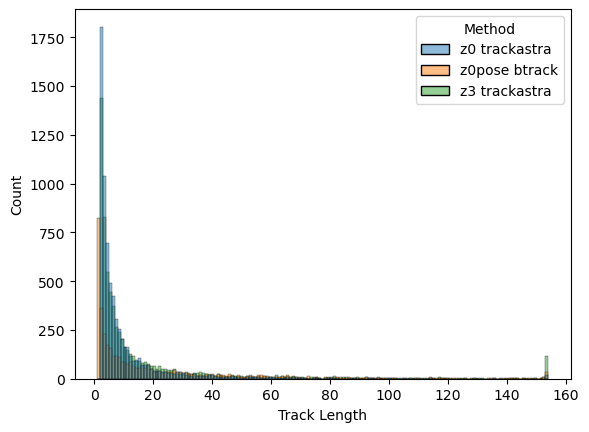

In [84]:
sns.histplot(data = track_lengths, x = 'Track Length', hue = 'Method')

<Axes: xlabel='Track Length', ylabel='Count'>

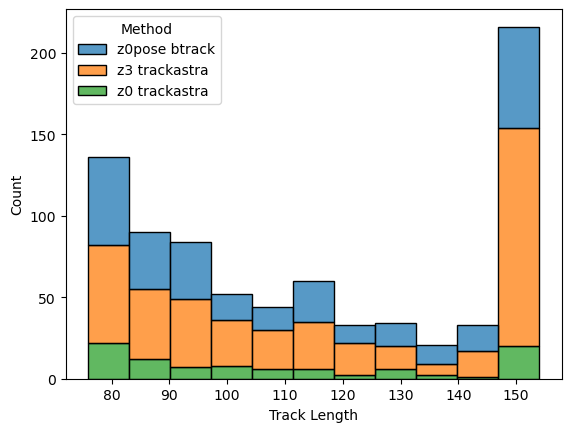

In [95]:
data = track_lengths[track_lengths['Track Length'] > 75]
sns.histplot(data = data, x = 'Track Length', hue = 'Method', multiple = 'stack')

In [94]:
z3tracks_df

,ID,T,X,Y,Method
0,1.0,0.0,5634.992622,5981.603725,z3 trackastra
1,1.0,1.0,5625.366020,5969.172972,z3 trackastra
2,1.0,2.0,5612.635863,5952.626192,z3 trackastra
3,1.0,3.0,5603.629704,5972.794765,z3 trackastra
4,1.0,4.0,5610.096183,6003.386241,z3 trackastra
...,...,...,...,...,...
126130,6977.0,153.0,2615.379869,4551.932644,z3 trackastra
126131,6978.0,152.0,5031.533171,5312.234936,z3 trackastra
126132,6978.0,153.0,5034.169569,5254.250189,z3 trackastra
126133,6979.0,152.0,5296.441637,623.781633,z3 trackastra


In [93]:
viewer.add_tracks(z3tracks_df[['ID', 'T', 'X', 'Y']].values, name = 'z3_tracks')

<Tracks layer 'z3_tracks' at 0x7fb44a0636d0>

In [122]:
filtered_tracks = z3tracks_df[z3tracks_df.groupby('ID')['T'].transform('count') >= 130]


In [123]:
len(filtered_tracks.ID.unique())

162

In [124]:
viewer.add_tracks(filtered_tracks[['ID', 'T', 'X', 'Y']].values, name = 'filtered at 130 frames')

<Tracks layer 'filtered at 130 frames' at 0x7fb481b61510>

### ultrafilter

In [111]:
# Imposing both lower and upper bounds on track length
ultrafiltered_tracks = z3tracks_df[(z3tracks_df.groupby('ID')['T'].transform('count') >= 75) & 
                                   (z3tracks_df.groupby('ID')['T'].transform('count') <= 130)]


In [113]:
len(ultrafiltered_tracks.ID.unique())

267

In [115]:
viewer.add_tracks(ultrafiltered_tracks[['ID', 'T', 'X', 'Y']].values, name = 'ultrafiltered')

<Tracks layer 'ultrafiltered [1]' at 0x7fb449bf1420>

# doubling times from trackastra

need to unite trackastra tracks with segmentation from cellpose Z0

In [125]:
tracks = z3tracks_df[z3tracks_df.groupby('ID')['T'].transform('count') >= 130]

In [127]:
viewer.layers['filtered at 130 frames'].scale = (10,1,1)

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [126]:
tracks

,ID,T,X,Y,Method
245,8.0,0.0,1316.925443,1308.419429,z3 trackastra
246,8.0,1.0,1296.484605,1236.577458,z3 trackastra
247,8.0,2.0,1301.557163,1220.274875,z3 trackastra
248,8.0,3.0,1290.174829,1210.652110,z3 trackastra
249,8.0,4.0,1330.836471,1218.764602,z3 trackastra
...,...,...,...,...,...
61876,2283.0,149.0,4957.993444,2788.832197,z3 trackastra
61877,2283.0,150.0,4961.470775,2788.063490,z3 trackastra
61878,2283.0,151.0,4957.135691,2776.889461,z3 trackastra
61879,2283.0,152.0,4963.660649,2778.348608,z3 trackastra
